<a href="https://colab.research.google.com/github/basilsaju383/ML_project1/blob/main/Time_series_anomaly_detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import keras
from keras import layers
from matplotlib import pyplot as plt

In [20]:
df = pd.read_excel('/content/sample_data/mc4 GSM 3 month.xlsx')
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df[['DateTime','RSSI']]
df = df.dropna()
df.head()

,DateTime,RSSI
1918,2023-11-30 15:30:00,-61.0
1925,2023-11-30 15:37:00,-62.0
1941,2023-11-30 15:53:00,-63.0
1956,2023-11-30 16:08:00,-66.0
1971,2023-11-30 16:23:00,-62.0


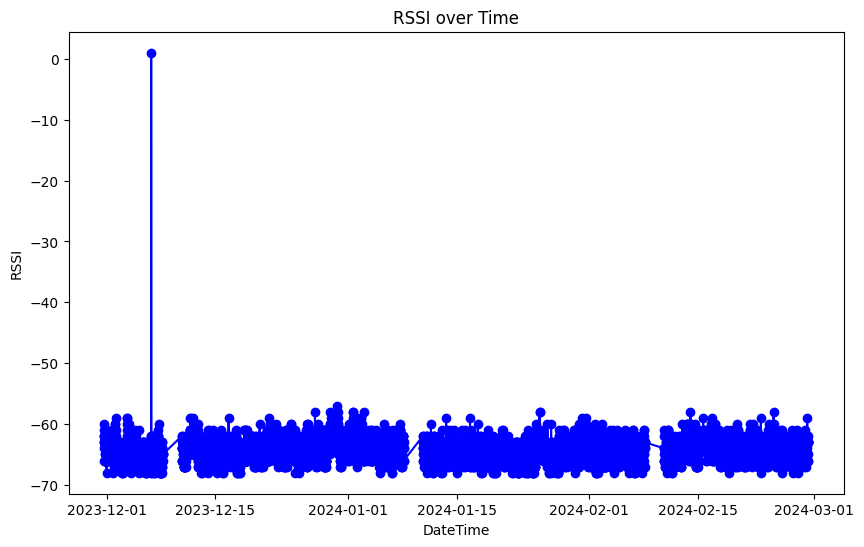

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(df['DateTime'], df['RSSI'], marker='o', linestyle='-', color='b')

# Adding labels and title
plt.xlabel('DateTime')
plt.ylabel('RSSI')
plt.title('RSSI over Time')

# Display the plot
plt.show()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4654 entries, 1918 to 132349
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  4654 non-null   datetime64[ns]
 1   RSSI      4654 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 109.1 KB


In [23]:

# Convert DateTime column to datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Separate the 'DateTime' column
df_datetime = df['DateTime']

# Drop the 'DateTime' column from the original DataFrame
df = df.drop('DateTime', axis=1)

# Calculate mean and standard deviation for the 'RSSI' column only
training_mean = df['RSSI'].mean()
training_std = df['RSSI'].std()

# Standardize the 'RSSI' values
df['RSSI_standardized'] = (df['RSSI'] - training_mean) / training_std
print("Number of training samples:", len(df))

# Reattach the 'DateTime' column
df['DateTime'] = df_datetime

# Display the DataFrame with standardized 'RSSI' values
print(df)



Number of training samples: 4654
        RSSI  RSSI_standardized            DateTime
1918   -61.0           1.616344 2023-11-30 15:30:00
1925   -62.0           1.133763 2023-11-30 15:37:00
1941   -63.0           0.651183 2023-11-30 15:53:00
1956   -66.0          -0.796558 2023-11-30 16:08:00
1971   -62.0           1.133763 2023-11-30 16:23:00
...      ...                ...                 ...
132287 -63.0           0.651183 2024-02-29 04:19:00
132303 -63.0           0.651183 2024-02-29 04:35:00
132318 -65.0          -0.313978 2024-02-29 04:50:00
132333 -63.0           0.651183 2024-02-29 05:05:00
132349 -66.0          -0.796558 2024-02-29 05:21:00

[4654 rows x 3 columns]


In [24]:
from sklearn.model_selection import train_test_split
TIME_STEPS = 300
df_training_value = df['RSSI_standardized']
X_train, X_test = train_test_split(df_training_value, test_size=0.2, random_state=42)

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(X_train.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3424, 300)


In [25]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(
            filters=16,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32,
            kernel_size=7,
            padding="same",
            strides=2,
            activation="relu",
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 150, 32)           256       
                                                                 
 dropout_2 (Dropout)         (None, 150, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 75, 16)            3600      
                                                                 
 conv1d_transpose_3 (Conv1D  (None, 150, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_3 (Dropout)         (None, 150, 16)           0         
                                                                 
 conv1d_transpose_4 (Conv1D  (None, 300, 32)           3616      
 Transpose)                                           

In [26]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
25/25 [==============================] - 3s 76ms/step - loss: 0.7006 - val_loss: 0.3832
Epoch 2/50
25/25 [==============================] - 2s 77ms/step - loss: 0.3138 - val_loss: 0.0832
Epoch 3/50
25/25 [==============================] - 3s 101ms/step - loss: 0.1631 - val_loss: 0.0423
Epoch 4/50
25/25 [==============================] - 2s 64ms/step - loss: 0.1294 - val_loss: 0.0332
Epoch 5/50
25/25 [==============================] - 2s 66ms/step - loss: 0.1137 - val_loss: 0.0265
Epoch 6/50
25/25 [==============================] - 2s 65ms/step - loss: 0.1039 - val_loss: 0.0235
Epoch 7/50
25/25 [==============================] - 2s 64ms/step - loss: 0.0974 - val_loss: 0.0217
Epoch 8/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0919 - val_loss: 0.0196
Epoch 9/50
25/25 [==============================] - 2s 65ms/step - loss: 0.0883 - val_loss: 0.0192
Epoch 10/50
25/25 [==============================] - 3s 112ms/step - loss: 0.0855 - val_loss: 0.0189
Epoch 1

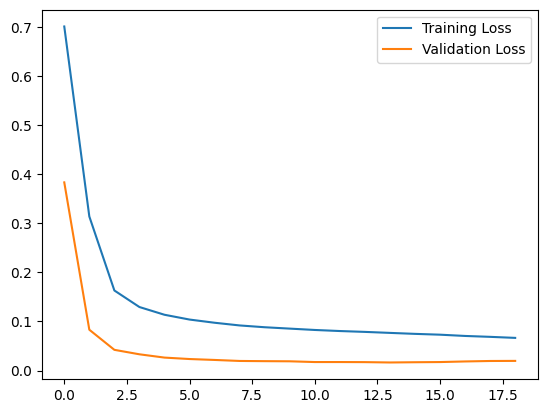

In [27]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

107/107 [==============================] - 1s 7ms/step


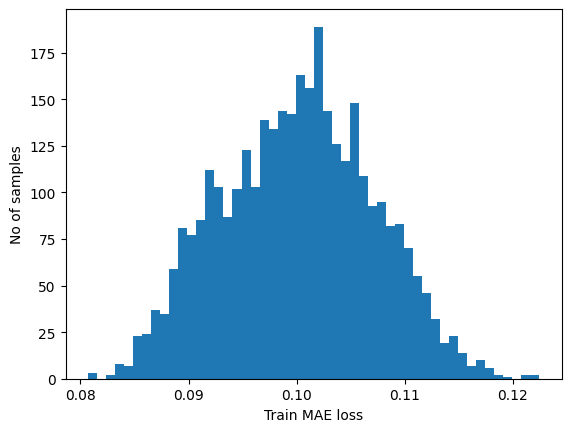

Reconstruction error threshold:  0.12242586023395097


In [28]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

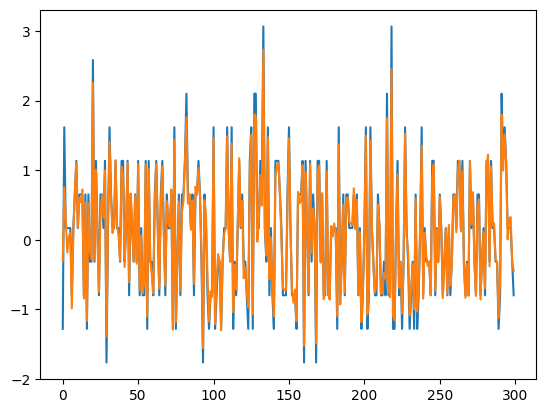

In [29]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [37]:
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_test = create_sequences(X_test.values)
print("Testing input shape: ", x_test.shape)


Testing input shape:  (632, 300)


In [38]:
X_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
model.evaluate(
    x=X_test_reshaped,
    y=X_test_reshaped,
    batch_size=64,
    verbose="auto",
    sample_weight=None,
    steps=None,
    callbacks=None,
    return_dict=False,
)


10/10 [==============================] - 0s 13ms/step - loss: 0.1315


0.13148337602615356